# K-Nearest Neighborhood Algorithm 
#### Brandon Novak

## Introduction

In this examination of the K-Nearest Neighbors algorithm, the Iris-Fisher dataset will be used to explore the predictive power of the algorithm. K-NN is a simple supervised machine learning classifier. The remainder of this examination is focused on the predictive power of the K-Nearest Neighbors algoirithm when handling data with few predictors and its advantages over a typical linear regression. The examination will continue with an introduction to the Iris-Fisher dataset. After which, there is a brief explanantion of the K-Nearest Neighbors algorithm, and finally, the analysis of the results of the K-NN algorithm on the Iris-Fisher Dataset.

### Iris-Fisher Dataset
The Iris-Fisher dataset is a collection of 150 observations of the Iris flower which was sampled in 1936. The dataset comprises 5 total variables, 4 predictors and 1 targeted output. The targeted output is the class identification of the Iris flower. The 4 predictors are the sepal length, sepal width, pedal length, and pedal width. All the predictor variables are in centimeters. This is helpful because standardization of the variables is not necessary because each measure distances. Below is a pairplot created from the package seaborn. The relationships of each variable are compared with one another. Additionally, the plots are helpful with distinguishing different trends and traits of each Iris class. 

In [1]:
import os
import time
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import os.path
import seaborn as sns
import matplotlib.pyplot as plt
import statistics 
from IPython.display import Image
figdir = "figures"

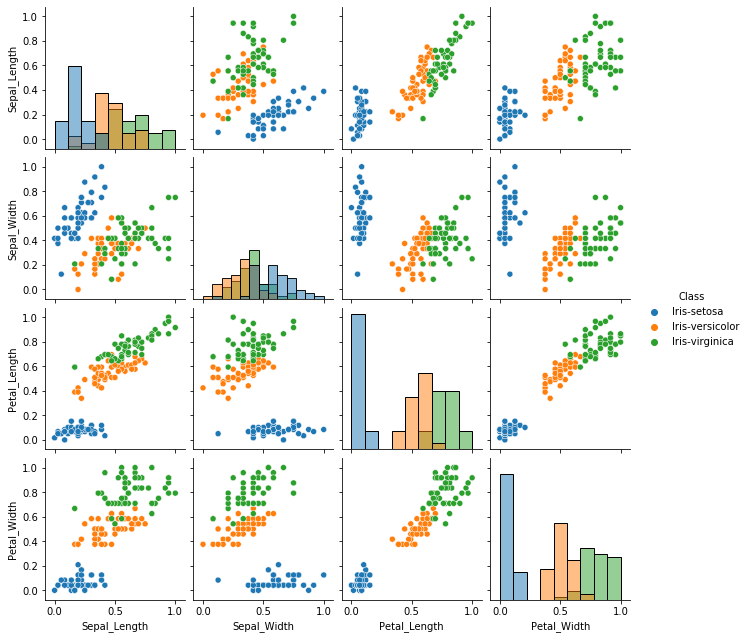

In [2]:
IrisDF = pd.read_csv("raw_iris_data_original.txt", names = ["Sepal_Length", "Sepal_Width", "Petal_Length", "Petal_Width", "Class"])
IrisDF["index"] = IrisDF.index
IrisDF = IrisDF.set_index("index")
#NORMALIZE DATA
IrisDF["Sepal_Length"] = (IrisDF["Sepal_Length"]-IrisDF["Sepal_Length"].min())/ (IrisDF["Sepal_Length"].max()-IrisDF["Sepal_Length"].min())
IrisDF["Sepal_Width"] = (IrisDF["Sepal_Width"]-IrisDF["Sepal_Width"].min())/ (IrisDF["Sepal_Width"].max()-IrisDF["Sepal_Width"].min())
IrisDF["Petal_Length"] = (IrisDF["Petal_Length"]-IrisDF["Petal_Length"].min())/ (IrisDF["Petal_Length"].max()-IrisDF["Petal_Length"].min())
IrisDF["Petal_Width"] = (IrisDF["Petal_Width"]-IrisDF["Petal_Width"].min())/ (IrisDF["Petal_Width"].max()-IrisDF["Petal_Width"].min())
sns.pairplot(IrisDF, hue = "Class", diag_kind = "hist", height = 2.25)
plt.show()

As we can see from the scatterplots and histograms above, there are many relationships and trends to take note of. The Iris-setosas tend to be the smallest in most categories except for the Sepal Width. The Iris-setosas tend to have the highest Sepal Width. In this experiment, I hypothesize the Iris-setosas will be easiest class for the algorithm to predict because their values in the scatterplots tend not to overlap with the Iris-versicolors nor the Iris-virginicas. On the other hand, I predict the the Iris-versicolors and the Iris-virginicas will comprise most of the inaccuracies in the algorithm. In almost every scatterplot, there are many overlapping points between the Iris-versicolors and the Iris-virginicas. These overlapping points are mostly likely to be the test points whose classes are going to be assigned incorrectly. However, we can see the  Iris-virginicas are typically larger than the Iris-versicolors. 

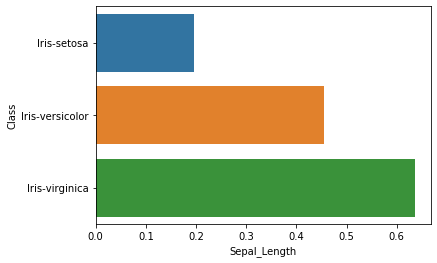

In [3]:
IrisDF_mean = IrisDF.groupby("Class").mean()
IrisDF_mean = IrisDF_mean.reset_index()
sns.barplot(x="Sepal_Length", y="Class", data=IrisDF_mean)

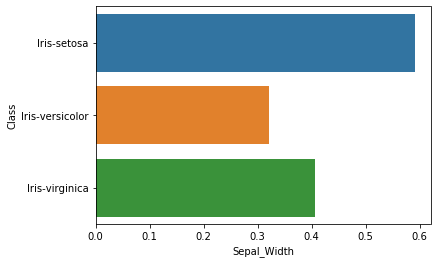

In [4]:
sns.barplot(x="Sepal_Width", y="Class", data=IrisDF_mean)

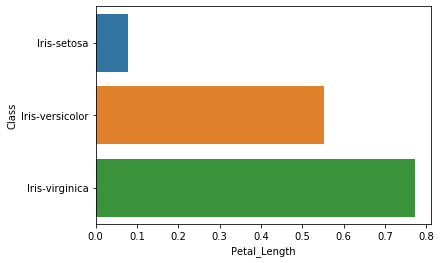

In [5]:
sns.barplot(x="Petal_Length", y="Class", data=IrisDF_mean)

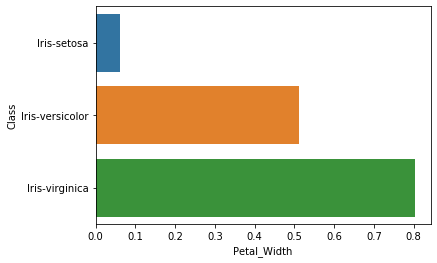

In [6]:
sns.barplot(x="Petal_Width", y="Class", data=IrisDF_mean)

The visual above is confirming some of trends that were discussed above. It is clear that the Iris-setosas' average category values are the smallest in every category except for the Sepal Width. Meanwhile, Iris-virginicas' average categories values remain the largest in all the other categories and the Iris-versicolors' average category values remain typically slightly smaller than the Iris-virginicas. This visual is a nice summary of the data to refer to when trying to understand the predictors of the dataset.

## Brief Review of K-NN algorithm

The K-Nearest Neighbors algorithm is an algorithm that computes the distances of each point from the training set to the testing point. The algorithm then sorts the training data points based off of the computed distances. The algorithm takes the first k amount of elements and the classifying variable that is most present becomes the testing point predicted value. K is a parameter that is decided by the user. In this analysis, the results of each k from 1 to 5 will analysed and we will see which k is the most accurate at predicting the classes of the testing data. The K-NN algorithm is extremely helpful as a predictor for datasets that have reasonable amount of predictors. Typically, a dataset with more predictive variables incrues the curse of dimensionality. With more dimensions, the model becomes less predictive and statistical significance dramatically decreases. 

In this use case of K-NN, k-folding was necessary to ensure the most accurate results of k are being found. Because there are only 150 observations in our dataset, each training point has a large influence over the prediction of the testing points. In each iteration of the k-fold, the training and test sets are randomly selected, then each iteration of the K-NN algorithm is performed on k = 1 through 5. Each iteration of k is stored and the average of the iterations is presented as the final accuracy. This process helps produce a more reliable accuracy of every k. The amount k-fold value used in the examination is 30. This means the training and test sets were chosen 30 different times and k=1 through 5 were ran on each sample.

In [7]:
def ReadData():
    IrisDF = pd.read_csv("raw_iris_data_original.txt", names = ["Sepal_Length", "Sepal_Width", "Petal_Length", "Petal_Width", "Class"])
    IrisDF["index"] = IrisDF.index
    IrisDF = IrisDF.set_index("index")

    #NORMALIZE DATA
    IrisDF["Sepal_Length"] = (IrisDF["Sepal_Length"]-IrisDF["Sepal_Length"].min())/ (IrisDF["Sepal_Length"].max()-IrisDF["Sepal_Length"].min())
    IrisDF["Sepal_Width"] = (IrisDF["Sepal_Width"]-IrisDF["Sepal_Width"].min())/ (IrisDF["Sepal_Width"].max()-IrisDF["Sepal_Width"].min())
    IrisDF["Petal_Length"] = (IrisDF["Petal_Length"]-IrisDF["Petal_Length"].min())/ (IrisDF["Petal_Length"].max()-IrisDF["Petal_Length"].min())
    IrisDF["Petal_Width"] = (IrisDF["Petal_Width"]-IrisDF["Petal_Width"].min())/ (IrisDF["Petal_Width"].max()-IrisDF["Petal_Width"].min())
    
    Setosas = IrisDF.loc[IrisDF["Class"] == "Iris-setosa"]
    Setosas.loc[:,"Class"] = 0
    Versicolors = IrisDF.loc[IrisDF["Class"] == 'Iris-versicolor']
    Versicolors.loc[:,"Class"] = 1
    Virginicas = IrisDF.loc[IrisDF["Class"] == "Iris-virginica"]
    Virginicas.loc[:,"Class"] = 2
    
    return Setosas, Versicolors, Virginicas

def CreateTrn_Tst_sets(Setosas, Versicolors, Virginicas):
    SetosasTrn = Setosas.sample(30)
    SetosasTst = Setosas.drop(SetosasTrn.index)

    VersicolorsTrn = Versicolors.sample(30)
    VersicolorsTst = Versicolors.drop(VersicolorsTrn.index)

    VirginicasTrn = Virginicas.sample(30)
    VirginicasTst = Virginicas.drop(VirginicasTrn.index)
    
    Train = SetosasTrn.merge(VersicolorsTrn, how = "outer")
    Train = Train.merge(VirginicasTrn, how = "outer")
    Test = SetosasTst.merge(VersicolorsTst, how = "outer")
    Test = Test.merge(VirginicasTst, how = "outer")

    TrainCategories = Train["Class"]
    TrainCategories = TrainCategories.to_numpy()
    Train = Train.drop(Train["Class"])
    TestCategories = Test["Class"]
    TestCategories = TestCategories.to_numpy()
    Test = Test.drop(Test["Class"])


    Train = Train.to_numpy()
    Test = Test.to_numpy()
    
    return Train, TrainCategories, Test, TestCategories

def knn(k, data, dataClass, inputs):
    nInputs = np.shape(inputs)[0]
    closest = np.zeros(nInputs)
    
    for n in range(nInputs):
        distances = np.sum((data-inputs[n,:])**2, axis =1)
        indices = np.argsort(distances, axis=0)
        classes = np.unique(dataClass[indices[:k]])
        if len(classes) == 1:
            closest[n] = np.unique(classes)
        else:
            counts = np.zeros(max(classes)+1)
            for i in range(k):
                counts[dataClass[indices[i]]] += 1
            closest[n] = np.argmax(counts)
    return closest

def main():
    Class1, Class2, Class3 = ReadData()
    DF_dict = {"k": [], "Accuracy": []}
    Count_Inaccuracies = [0,0,0]
    for i in range(30):
        Train, TrainCategories, Test, TestCategories = CreateTrn_Tst_sets(Class1, Class2, Class3)
        results =[]
        for j in range(5):
            predicted = knn(j+1, Train, TrainCategories, Test)
            accuracy = 0
            for count, pred in enumerate(predicted):
                if pred == TestCategories[count]:
                    accuracy = accuracy + 1
                else:
                    Count_Inaccuracies[TestCategories[count]] = Count_Inaccuracies[TestCategories[count]] + 1
            results.append(accuracy/(len(Test)) *100)
            DF_dict["k"].append(j+1)
            DF_dict["Accuracy"].append(accuracy/(len(Test)) *100)
    totalResults = statistics.mean(results)
    resultsDF = pd.DataFrame(data = DF_dict, columns = ["k", "Accuracy"])
    Inaccuracies_DF = pd.DataFrame(data = Count_Inaccuracies, columns = ["count_of_inaccuracies"])
    index = ["Iris-setosas", "Iris-versicolors", "Iris-virginicas"]
    Inaccuracies_DF["Class"] = index
    Inaccuracies_DF = Inaccuracies_DF[["Class", "count_of_inaccuracies"]]
    return totalResults, resultsDF, Inaccuracies_DF
total_results, t_resultsDF, Inaccuracy_count = main()
Final_Results= t_resultsDF.groupby("k", as_index = False).mean()

## Results

Below is the results of running the K-NN algorithm on the Iris Dataset when k is 1 through 5. The variable being used to represent the results is <code> Final_Results </code> which is a pandas average aggregation of each k.

In [8]:
Final_Results

,k,Accuracy
0,1,84.502924
1,2,79.649123
2,3,88.362573
3,4,87.076023
4,5,89.005848


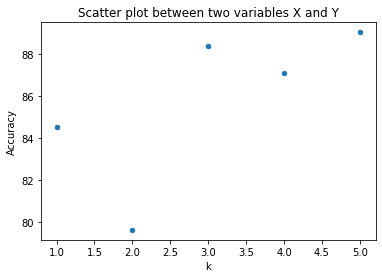

In [9]:
import matplotlib.pyplot as plot
Final_Results.plot.scatter(x='k', y='Accuracy', title= "Scatter plot between two variables X and Y");
plot.show(block=True);

The most successful k-values at predicting the class of the Iris-Fisher dataset was 5 and 3. K = 5 was the most effective in accurately labeling the class of the test points with an overall accuracy of 89.1%. This means that the algorithm correctly identified the test points' class 89.1% of the time. When k = 3, the results were also very impressive with a total accuracy of 88.4%. However, it should be noted that these values will change everytime this algorithm is run because algorithm variance is present, and the training and test sets are chosen randomly from a relatively small dataset. Nevertheless, 3 and 5 tend to be the most accurate k values and tend stay around 88.4% and 89.1%, respectively. My hypothesis was that the Iris-versicolors and the Iris-virginicas would be the most susceptible to be mislabeled. The table labeled as <code> Inaccuracy_count </code> will show us how the mislabeled test points were distributed among the classes. 

In [10]:
Inaccuracy_count

,Class,count_of_inaccuracies
0,Iris-setosas,412
1,Iris-versicolors,585
2,Iris-virginicas,224


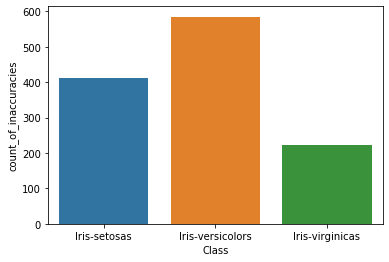

In [11]:
sns.barplot(x="Class", y="count_of_inaccuracies", data=Inaccuracy_count)

This result disproves my hypothesis. The two classes that the algorithm struggled the most were Iris-setosas and Iris-versicolors. I did expect the Iris-versicolors to be tough for the algorithm to predict. As indicated in the matrix chart that is displayed in the introduction, the Iris-versicolors were the class that was never in an extreme of the predictor variables. Except for the Sepal Width, the Iris-setosas and the Iris-virginicas occupy the smallest and largest values, respectively. However, the pairplot indicated that the Iris-versicolors and the Iris-virginicas had the most amount of overlap. This was the basis of my hypothesis. As a result, this suggests there must be another factor that influneces the difficulty of predicting a class.

The final results of this examination of the K-Nearest Neighbors was successful. The most successful k values at predicting the correct classes were 3 and 5. Additionally, the study found the Iris-versicolors accounted for most of the inaccuracies in this implementation of the algorithm. On the other hand, the algorithm was most successful at predicting Iris-virginicas. The K-NN is a great classifying algorithm when the dimensions are manageable and can often provides more accurate predictions than a standard linear model. 

# Code Appendix

Below is the code appendix. This is the clean code that is used to perform the K-NN algorithm. This appendix does not include the code for visuals

#### Reading in Data

In [12]:
def ReadData():
    IrisDF = pd.read_csv("raw_iris_data_original.txt", names = ["Sepal_Length", "Sepal_Width", "Petal_Length", "Petal_Width", "Class"])
    IrisDF["index"] = IrisDF.index
    IrisDF = IrisDF.set_index("index")

    #NORMALIZE DATA
    IrisDF["Sepal_Length"] = (IrisDF["Sepal_Length"]-IrisDF["Sepal_Length"].min())/ (IrisDF["Sepal_Length"].max()-IrisDF["Sepal_Length"].min())
    IrisDF["Sepal_Width"] = (IrisDF["Sepal_Width"]-IrisDF["Sepal_Width"].min())/ (IrisDF["Sepal_Width"].max()-IrisDF["Sepal_Width"].min())
    IrisDF["Petal_Length"] = (IrisDF["Petal_Length"]-IrisDF["Petal_Length"].min())/ (IrisDF["Petal_Length"].max()-IrisDF["Petal_Length"].min())
    IrisDF["Petal_Width"] = (IrisDF["Petal_Width"]-IrisDF["Petal_Width"].min())/ (IrisDF["Petal_Width"].max()-IrisDF["Petal_Width"].min())
    
    #SPLIT DATA INTO CLASSES
    Setosas = IrisDF.loc[IrisDF["Class"] == "Iris-setosa"]
    Setosas.loc[:,"Class"] = 0
    Versicolors = IrisDF.loc[IrisDF["Class"] == 'Iris-versicolor']
    Versicolors.loc[:,"Class"] = 1
    Virginicas = IrisDF.loc[IrisDF["Class"] == "Iris-virginica"]
    Virginicas.loc[:,"Class"] = 2
    
    IrisDF
    
    return Setosas, Versicolors, Virginicas

#### Creating Training and Test Sets

In [13]:
def CreateTrn_Tst_sets(Setosas, Versicolors, Virginicas):
    
    #CREATE TRAIN AND TEST SETS OF CLASS
    SetosasTrn = Setosas.sample(30)
    SetosasTst = Setosas.drop(SetosasTrn.index)

    VersicolorsTrn = Versicolors.sample(30)
    VersicolorsTst = Versicolors.drop(VersicolorsTrn.index)

    VirginicasTrn = Virginicas.sample(30)
    VirginicasTst = Virginicas.drop(VirginicasTrn.index)
    
    #MERGE TRAIN SETS TOGETHER AND MERGE TEST SETS TOGETHER
    Train = SetosasTrn.merge(VersicolorsTrn, how = "outer")
    Train = Train.merge(VirginicasTrn, how = "outer")
    Test = SetosasTst.merge(VersicolorsTst, how = "outer")
    Test = Test.merge(VirginicasTst, how = "outer")

    #CREATE CATEGORIES LIST     
    TrainCategories = Train["Class"]
    TrainCategories = TrainCategories.to_numpy()
    Train = Train.drop(Train["Class"])
    TestCategories = Test["Class"]
    TestCategories = TestCategories.to_numpy()
    Test = Test.drop(Test["Class"])


    Train = Train.to_numpy()
    Test = Test.to_numpy()
    
    return Train, TrainCategories, Test, TestCategories

#### Perform K-NN Algorithm

In [14]:
def knn(k, data, dataClass, inputs):
    nInputs = np.shape(inputs)[0]
    closest = np.zeros(nInputs)
    
    for n in range(nInputs):
        distances = np.sum((data-inputs[n,:])**2, axis =1)
        indices = np.argsort(distances, axis=0)
        classes = np.unique(dataClass[indices[:k]])
        if len(classes) == 1:
            closest[n] = np.unique(classes)
        else:
            counts = np.zeros(max(classes)+1)
            for i in range(k):
                counts[dataClass[indices[i]]] += 1
            closest[n] = np.argmax(counts)
    return closest

#### K-Folding and defining main()

In [15]:
def main(): 

    Class1, Class2, Class3 = ReadData()
    DF_dict = {"k": [], "Accuracy": []}
    for i in range(30):
        Train, TrainCategories, Test, TestCategories = CreateTrn_Tst_sets(Class1, Class2, Class3)
        results =[]
        for j in range(5):
            predicted = knn(j+1, Train, TrainCategories, Test)
            accuracy = 0
            for count, pred in enumerate(predicted):
                if pred == TestCategories[count]:
                    accuracy = accuracy + 1
            results.append(accuracy/(len(Test)) *100)
            DF_dict["k"].append(j+1)
            DF_dict["Accuracy"].append(accuracy/(len(Test)) *100)
    totalResults = statistics.mean(results)
    resultsDF = pd.DataFrame(data = DF_dict, columns = ["k", "Accuracy"])
    return totalResults, resultsDF

In [16]:
import os
import pandas as pd
import numpy as np
import os.path
import seaborn as sns
import statistics
main()

(85.26315789473684,      k   Accuracy
 0    1  85.964912
 1    2  85.964912
 2    3  89.473684
 3    4  89.473684
 4    5  89.473684
 ..  ..        ...
 145  1  85.964912
 146  2  82.456140
 147  3  85.964912
 148  4  84.210526
 149  5  87.719298
 
 [150 rows x 2 columns])